# Survey of evacuation shelters in Shibuya Ward
---

## Import required modules

In [ ]:
!pip install folium
!pip install geopy
!pip install python-dotenv

In [280]:
import numpy as np
import pandas as pd
import os
import folium
import requests
from dotenv import load_dotenv
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
from tqdm import tqdm

%matplotlib inline
warnings.simplefilter('ignore')

## Read data from shelters in Shibuya Ward

In [299]:
df_evacuation = pd.read_csv('datasets/131130_evacuation_space.csv')
df_evacuation = df_evacuation[[ '名称', '緯度', '経度']]
df_evacuation = df_evacuation.rename(columns={'名称': 'Name',  '緯度': 'Latitude', '経度': 'Longitude'})
# df_evacuation.head()
df_evacuation

,Name,Latitude,Longitude
0,景丘公園,35.644016,139.713218
1,アメリカ橋公園,35.642655,139.715600
2,あいおいニッセイ同和損保前,35.647677,139.715599
3,恵比寿東公園,35.648177,139.711750
4,広尾公園,35.648526,139.721939
...,...,...,...
113,鳩森小学校,35.682404,139.706001
114,千駄谷小学校,35.675167,139.707739
115,神宮前小学校,35.667801,139.708100
116,ケアコミュニティ・原宿の丘,35.679944,139.679647


## Get location information for Shibuya Ward

In [282]:
address = 'Shibuya, Tokyo, Japan'
geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print(f'The geographical coordinate of Tronto are {latitude}, {longitude}')

The geographical coordinate of Tronto are 35.6645956, 139.6987107


## Definition of required functions

In [283]:
def create_map(map, df):
    """
    Create the folium map and set the marker
    """
    
    for name, lat, lng in zip(df['Name'], df['Latitude'], df['Longitude']):
        label = f'{name}'
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map)  
    
    return map

In [284]:
def jap_map(base_map, geojson_path):
    """
    Draw a ward boundary based on geojason
    """
    base_map.choropleth(geo_data=geojson_path, 
                        line_color="red", 
                        line_weight=2, 
                        fill_color='white', 
                        fill_opacity=0.1, 
                        line_opacity=1)

## Display a map of Shibuya Ward and markers for shelters

In [285]:
map = folium.Map(location=[latitude, longitude], zoom_start=13)
map = create_map(map, df_evacuation)
jap_map(base_map=map, geojson_path='datasets/shibuya.json')

map

## Cluster evacuation centers in Shibuya Ward

In [286]:
num = 3

grouped_clustering = df_evacuation.drop('Name', 1)

pred = KMeans(n_clusters=num, random_state=0).fit_predict(grouped_clustering)
# kmeans = KMeans(n_clusters=num, random_state=0).fit(grouped_clustering)
pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 2, 0, 2], dtype=int32)

In [302]:
df_evacuation['cluster_id'] = pred
df_evacuation.head(5)

,Name,Latitude,Longitude,cluster_id
0,景丘公園,35.644016,139.713218,1
1,アメリカ橋公園,35.642655,139.715600,1
2,あいおいニッセイ同和損保前,35.647677,139.715599,1
3,恵比寿東公園,35.648177,139.711750,1
4,広尾公園,35.648526,139.721939,1


## Count the number of shelters per cluster

In [288]:
df_evacuation.groupby('cluster_id').count()

,Name,Latitude,Longitude
cluster_id,,,
0,54,54,54
1,36,36,36
2,28,28,28


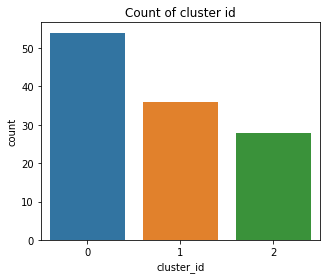

In [289]:
plt.figure(figsize=(5, 4))
sns.countplot(x='cluster_id', data=df_evacuation)
plt.title('Count of cluster id')

plt.show()

## Map clustered shelters

In [290]:
colors_array = ['red','brown','green']

map_shibuya = folium.Map(location=[latitude, longitude], zoom_start=11)
jap_map(base_map=map_shibuya, geojson_path='datasets/shibuya.json')

for name, lat, lon, cluster in zip(df_evacuation['Name'], df_evacuation['Latitude'], df_evacuation['Longitude'], df_evacuation['cluster_id']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=name,
        color=colors_array[cluster-1],
        fill=True,
        fill_color=colors_array[cluster-1],
        fill_opacity=0.7).add_to(map_shibuya)

map_shibuya

## Get a venue around the shelter

In [291]:
load_dotenv(verbose=True)
load_dotenv('.env')

CLIENT_ID = os.environ.get("CLIENT_ID")
CLIENT_SECRET = os.environ.get("CLIENT_SECRET")
VERSION = '20180605'
LIMIT = 10

In [292]:
def getNearbyVenues(names, latitudes, longitudes, cluster_ids, radius=500):
    
    venues_list=[]
    for name, lat, lng, cluster_id in tqdm(zip(names, latitudes, longitudes, cluster_ids), total=len(names)):

        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={radius}&limit={LIMIT}'

        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            cluster_id,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Name', 
                  'Latitude', 
                  'Longitude', 
                  'cluster_id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [293]:
shibuya_venues = getNearbyVenues(names=df_evacuation['Name'],
                                latitudes=df_evacuation['Latitude'],
                                longitudes=df_evacuation['Longitude'],
                                cluster_ids=df_evacuation['cluster_id'])

100%|██████████| 118/118 [01:08<00:00,  1.72it/s]


## Add the acquired venue marker

In [294]:
colors_array = ['red','brown','green']

map_shibuya = folium.Map(location=[latitude, longitude], zoom_start=14)

jap_map(base_map=map_shibuya, geojson_path='datasets/shibuya.json')

for name, lat, lon, cluster in zip(df_evacuation['Name'], df_evacuation['Latitude'], df_evacuation['Longitude'], df_evacuation['cluster_id']):
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=name,
        color=colors_array[cluster-1],
        fill=True,
        fill_color=colors_array[cluster-1],
        fill_opacity=0.7).add_to(map_shibuya)

for name, lat, lon in zip(shibuya_venues['Venue'], shibuya_venues['Venue Latitude'], shibuya_venues['Venue Longitude']):
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        fill=True,
        popup=name,
        fill_opacity=0.7).add_to(map_shibuya)
    
    
map_shibuya

## Count by venue category

In [295]:
shibuya_venues.groupby('Venue Category').count()

,Name,Latitude,Longitude,cluster_id,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,,
Accessories Store,2,2,2,2,2,2,2
American Restaurant,4,4,4,4,4,4,4
Art Gallery,7,7,7,7,7,7,7
Art Museum,11,11,11,11,11,11,11
Arts & Crafts Store,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...
Wine Shop,3,3,3,3,3,3,3
Xinjiang Restaurant,1,1,1,1,1,1,1
Yakitori Restaurant,5,5,5,5,5,5,5


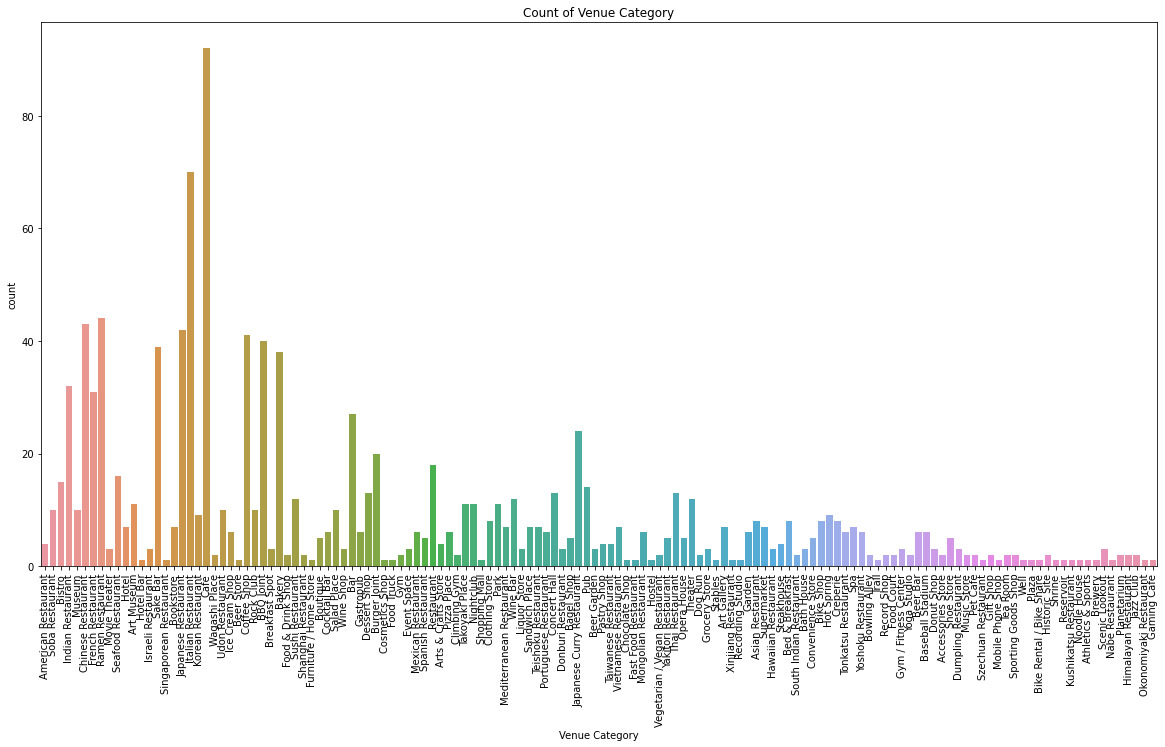

In [296]:
plt.figure(figsize=(20, 10))
sns.countplot(x='Venue Category', data=shibuya_venues)
plt.xticks(rotation=90)

plt.title('Count of Venue Category')
plt.show()

## Count venue categories by cluster id

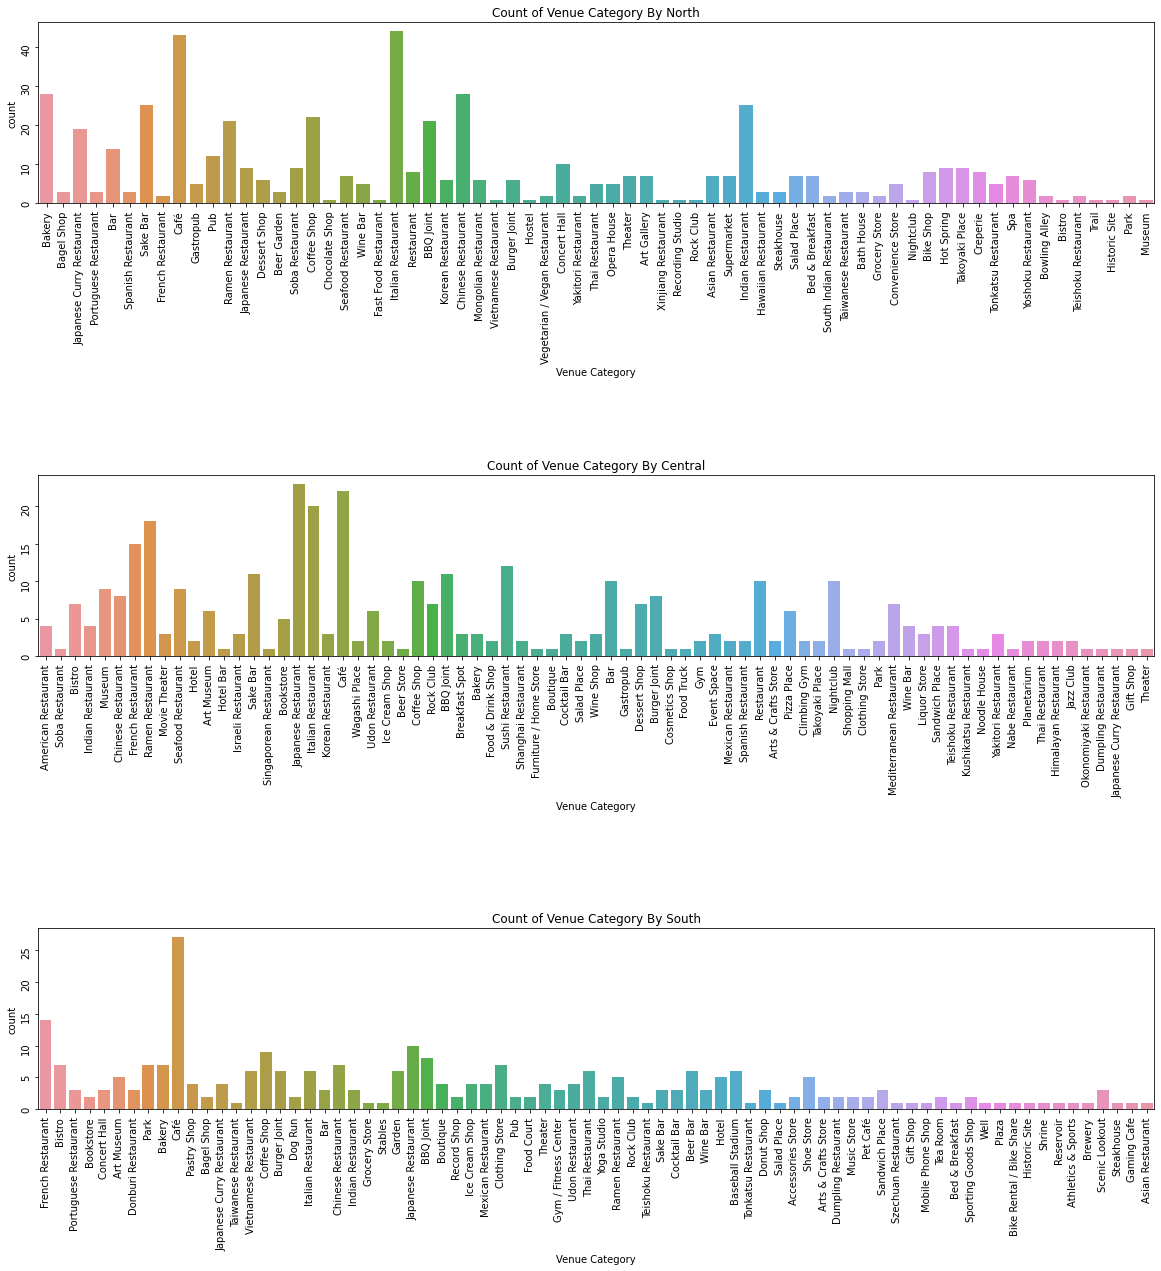

In [297]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
category_names = ['North', 'Central', 'South']

for i, (ax, category_name) in enumerate(zip(axs, category_names)):
    sns.countplot(x='Venue Category', data=shibuya_venues[shibuya_venues['cluster_id'] == i], ax=ax)
    ax.tick_params(labelrotation=90)
    ax.set_title(f'Count of Venue Category By {category_name}')
    
plt.subplots_adjust(wspace=0.4, hspace=1.5)
plt.show()